# Residual Plot Analysis — ExoALMA Data

This notebook analyzes residual plots from the ExoALMA program (Curone et al. 2025, Paper IV) to extract flux limits potentially associated with planet-forming signatures within the annuli of protoplanetary disks. The aim is not to spatially characterize these features — which are likely unresolved — but to constrain potential circumplanetary disk (CPD) properties using up-to-date CPD emission models, and to compare model performance in terms of predictive power.

**Reference**:  
Curone, P., Facchini, S., Andrews, S. M., et al. (2025). *exoALMA. IV. Substructures, Asymmetries, and the Faint Outer Disk in Continuum Emission*. *The Astrophysical Journal Letters*, **984**(1), L9. https://doi.org/10.3847/2041-8213/adc438


In [1]:
# import necessary libraries

import os  
import numpy as np  
import re  # Python’s regular expressions module to extract numbers from filenames
from astropy.io import fits
import pandas as pd
from gofish import imagecube
import matplotlib.pyplot as plt
from disk_residuals import DiskResiduals


# Add a paragraph to describe the class

In [2]:
# -----------------------------------------------------
# Load all disks into a dictionary of DiskResiduals objects
# -----------------------------------------------------
data_dir = "D:/exoALMA_disk_data"  # Use forward slashes for Windows or raw string

# Load disk distances from file 
dist_df = pd.read_csv("disk_distances.txt", comment="#", names=["disk_name", "distance_pc"])
distance_dict = dict(zip(dist_df["disk_name"], dist_df["distance_pc"]))  # dict() and zip() difference: zip*) pairs element like ('AA_tau', 140.0) , and dict() turns it to {'AA_Tau': 140.0}


all_disks = {}



for disk in os.listdir(data_dir):
    res_path = os.path.join(data_dir, disk, "images_frank_residuals_different_robust")
    clean_path = os.path.join(data_dir, disk, "images_data_different_robust")
    geom_file = os.path.join(data_dir, disk, f"{disk}_geometrical_parameters_continuum_galario.txt")
    clean_profile_file = os.path.join(data_dir, disk, f"{disk}_CLEAN_profile_robust-05.txt")
    radii_file = os.path.join(data_dir, disk, f"{disk}_continuum_radii.txt")
    ringgap_file = os.path.join(data_dir, disk, f"{disk}_gaps_rings_continuum.txt")

    if os.path.isdir(res_path) and os.path.exists(geom_file):
        disk_obj = DiskResiduals(disk, res_path, geom_file)
        disk_obj.load_residuals()
        if os.path.isdir(clean_path):
            disk_obj.load_clean_images(clean_path)
        if os.path.exists(clean_profile_file):
            disk_obj.load_clean_profile(clean_profile_file)
        disk_obj.distance_pc = distance_dict.get(disk, None)
        # Load R90 and gap/ring info if files exist
        if os.path.exists(radii_file):
            disk_obj.load_disksize(radii_file)
        if os.path.exists(ringgap_file):
            arr = np.loadtxt(ringgap_file, comments="#")
            if arr.ndim == 1:
                arr = arr[np.newaxis, :]  # Make it 2D if only one row
            disk_obj.ringgap = arr
        all_disks[disk] = disk_obj

print(f"DiskResiduals is a class that contains {len(all_disks)} disks with their residuals loaded. \nall_disks is a dictionary with disk names as keys and DiskResiduals objects as values.\ndisk_obj is an object of DiskResiduals class that contains the residuals and geometries for each disk.")

DiskResiduals is a class that contains 15 disks with their residuals loaded. 
all_disks is a dictionary with disk names as keys and DiskResiduals objects as values.
disk_obj is an object of DiskResiduals class that contains the residuals and geometries for each disk.


In [3]:
# Clean the keys in the residuals dictionary

#clean residuals keys: remove trailing dots so keys match sigma_masks

for disk_name, disk_obj in all_disks.items():
    old_residuals = dict(disk_obj.residuals) # Create a copy of the original residuals
    disk_obj.residuals.clear() # Clear the original residuals dictionary
    for key, value in old_residuals.items():
        clean_key = key.rstrip('.')  # Remove trailing dot(s)
        disk_obj.residuals[clean_key] = value # Assign the cleaned key with its value

In [4]:
# Display a summary of all_disks objects

for disk_name, disk_obj in all_disks.items():
    print(f"Disk: {disk_name}")
    print(f"  Inclination: {disk_obj.inc:.2f} deg")
    print(f"  PA: {disk_obj.PA:.2f} deg")
    print(f"  Center offset: {disk_obj.center}")  # .center is a tuple (dRA, dDec)
    print(f"  Residuals (Briggs indices): {list(disk_obj.residuals.keys())}") # .keys() to get the keys of the dictionary , list() to convert it to a list, keys are the Briggs indices , apart from keys are the values of the dictionary which are the FITS data
    print("-" * 40)

Disk: AA_Tau
  Inclination: 58.54 deg
  PA: 93.77 deg
  Center offset: (-0.00545897, 0.00482739)
  Residuals (Briggs indices): ['0.0', '-0.5', '0.5', '-1.0', '1.0', '-1.5', '-2.0', '2.0']
----------------------------------------
Disk: CQ_Tau
  Inclination: 35.24 deg
  PA: 53.87 deg
  Center offset: (-0.00871044, 0.0009941)
  Residuals (Briggs indices): ['0.0', '-0.5', '0.5', '-1.0', '1.0', '-1.5', '1.5', '-2.0', '2.0']
----------------------------------------
Disk: DM_Tau
  Inclination: 35.97 deg
  PA: 155.60 deg
  Center offset: (-0.00551499, -0.00658999)
  Residuals (Briggs indices): ['0.0', '-0.5', '0.5', '-1.0', '1.0', '-1.5', '1.5', '-2.0', '2.0']
----------------------------------------
Disk: HD_135344B
  Inclination: 20.73 deg
  PA: 28.92 deg
  Center offset: (0.0007974, -0.00320815)
  Residuals (Briggs indices): ['0.0', '-0.5', '0.5', '-1.0', '1.0', '-1.5', '1.5', '-2.0', '2.0']
----------------------------------------
Disk: HD_143006
  Inclination: 18.69 deg
  PA: 7.53 deg
  C

In [5]:
# Plotting the Disk Residuals

In [6]:
# Plot the residual radial profile for each disk overlaid on the full disk profile
# Need to add the geometry of the disk to the class
# add a method to the class to plot the residual radial profile
# change the class to not only store the residuals, but all the information about the disk
# and label them clearly
# Problem: the displayed image is not the same as shown in paper, this has units of flux, that one is SNR
# How to measure the noise then? 

The frank model generates synthetic visibilities, which are subtracted from the observed visibilities to produce residual visibilities. These residuals are then imaged using the CLEAN algorithm, resulting in a residual map. Like other radio continuum images, this map has units of flux density per beam (e.g., Jy/beam). To express the residuals in terms of signal-to-noise ratio (SNR), as done in Figure 3 of the exoALMA IV paper, the observed rms noise corresponding to each robust weighting must be extracted from the original image and used to rescale the residual flux densities.

However, since protoplanetary disks are best studied in concentric radial rings from the central star, it's important to consider that the noise level varies with radius. At larger disk radii, more ALMA beams cover each ring, which reduces the azimuthally averaged noise. In contrast, the inner disk tends to show brighter emission but fewer independent beams per bin. Therefore, the azimuthally averaged rms noise within each radial ring provides the most effective way to separate planet-induced substructure signals from noise.

Made a simple example plot of the nonaxisymmetric residuals for disk AA_Tau with robust value 0.5 to check if GoFish works

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


Text(0, 0.5, 'Intensity (Jy sr^-1)')

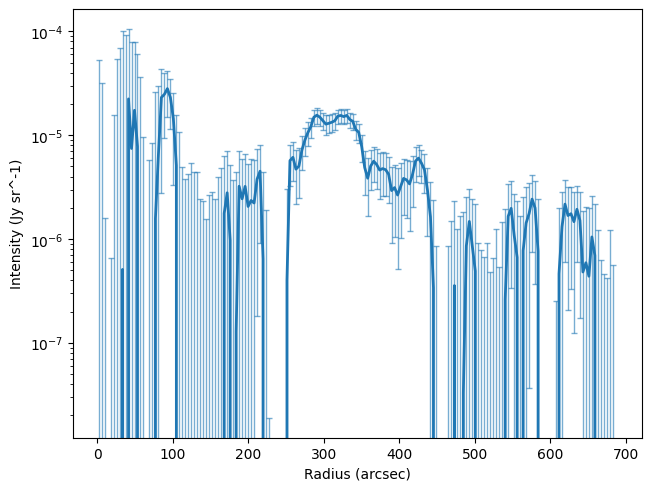

In [7]:
# A simple example plot of the nonaxisymmetric residuals for disk AA_Tau with robust value 0.5
# Adapting from section 4.2 of the exoALMA IV paper
# Keep the unit as Jy/beam at the moment, despite paper uses Jy/sr

cube = all_disks["AA_Tau"].get_cube("1.0", cube_type="residual")
#cube = imagecube('D:\exoALMA_disk_data\AA_Tau\images_frank_residuals_different_robust\AA_Tau_continuum_resid_robust0.5.image.fits', FOV=10.0)

x, y, dy = cube.radial_profile(inc=all_disks["AA_Tau"].inc, PA=all_disks["AA_Tau"].PA, unit='Jy/beam', dist=all_disks["AA_Tau"].distance_pc)  # return_au=False by default, so x is in arcsec
x=x * all_disks["AA_Tau"].distance_pc 
fig, ax = plt.subplots(constrained_layout=True)
# Plot the main line with a thicker width
ax.plot(x, y, color='C0', linewidth=2, label='Profile')
# Overlay lighter error bars
ax.errorbar(x, y, dy, fmt='none', ecolor='C0', alpha=0.6, elinewidth=1, capsize=2, label='Uncertainty')
ax.set_yscale('log')
ax.set_xlabel('Radius (arcsec)')  # nope, please be in au
ax.set_ylabel('Intensity (Jy sr^-1)')



# First , plot the full disk profile -> change the axes labels and calculations -> load the residuals 


And for the clean image to check if the result matches publication

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


Text(0, 0.5, 'Intensity (Jy beam^-1)')

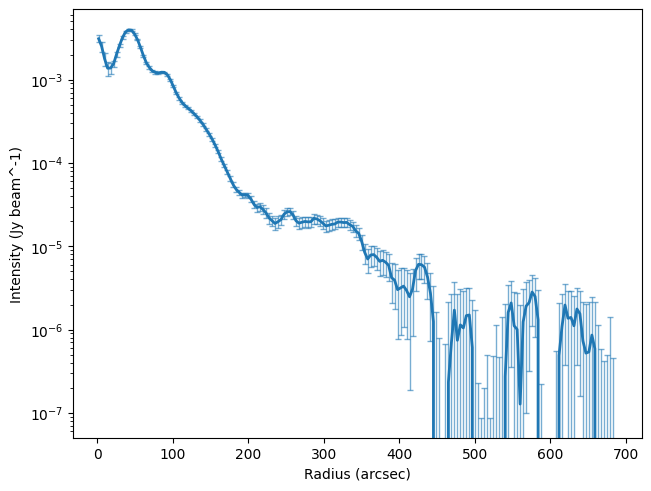

In [8]:
cube_cl = all_disks["AA_Tau"].get_cube("1.0", cube_type="clean")

x, y, dy = cube_cl.radial_profile(inc=all_disks["AA_Tau"].inc, PA=all_disks["AA_Tau"].PA, unit='Jy/beam')
x=x * all_disks["AA_Tau"].distance_pc 
fig, ax = plt.subplots(constrained_layout=True)
# Plot the main line with a thicker width
ax.plot(x, y, color='C0', linewidth=2, label='Profile')
# Overlay lighter error bars
ax.errorbar(x, y, dy, fmt='none', ecolor='C0', alpha=0.6, elinewidth=1, capsize=2, label='Uncertainty')
ax.set_yscale('log')
ax.set_xlabel('Radius (arcsec)')  # nope, please be in au
ax.set_ylabel('Intensity (Jy beam^-1)')




Checking that the plot_profile function in the DiskResidual class works.

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


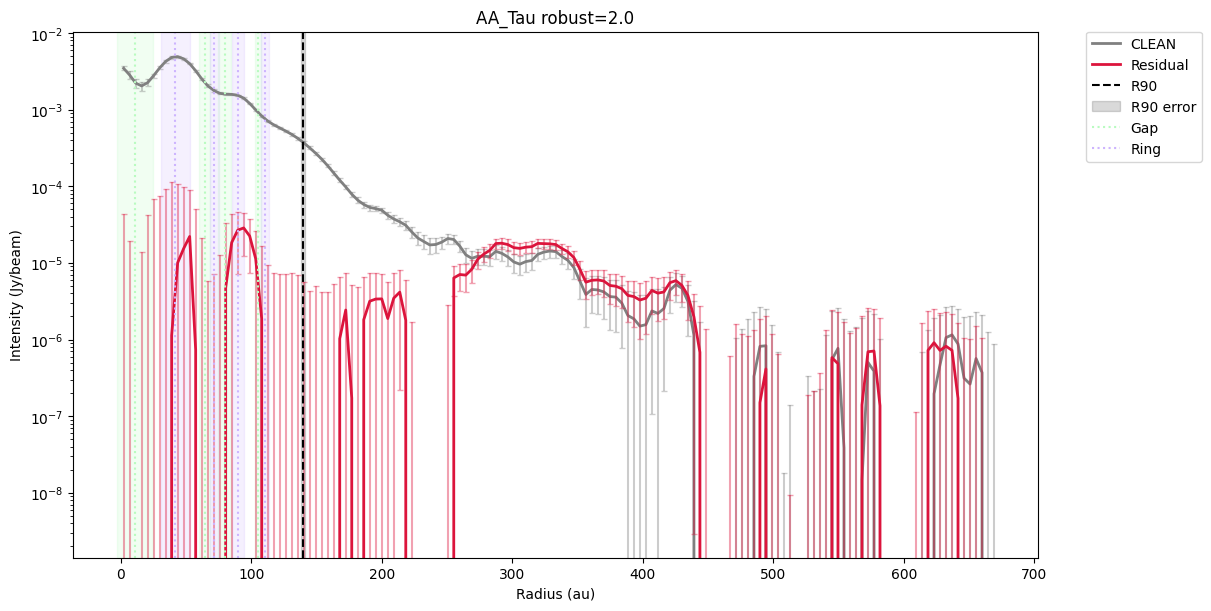

In [9]:
# unit transformation from Jy/beam to Jy/sr
# Jy/beam = Jy/sr * (beam area in sr)
# beam area extracted from the header of the FITS file

# --- IGNORE ---
# unit transformation from arcsec to au
# distance pc is NOT stored in the header of the FITS file


# Adapted from table 1 of the exoALMA X paper

all_disks["AA_Tau"].plot_profiles(robust_val="2.0", radius_unit="au")


Plotting: AA_Tau
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


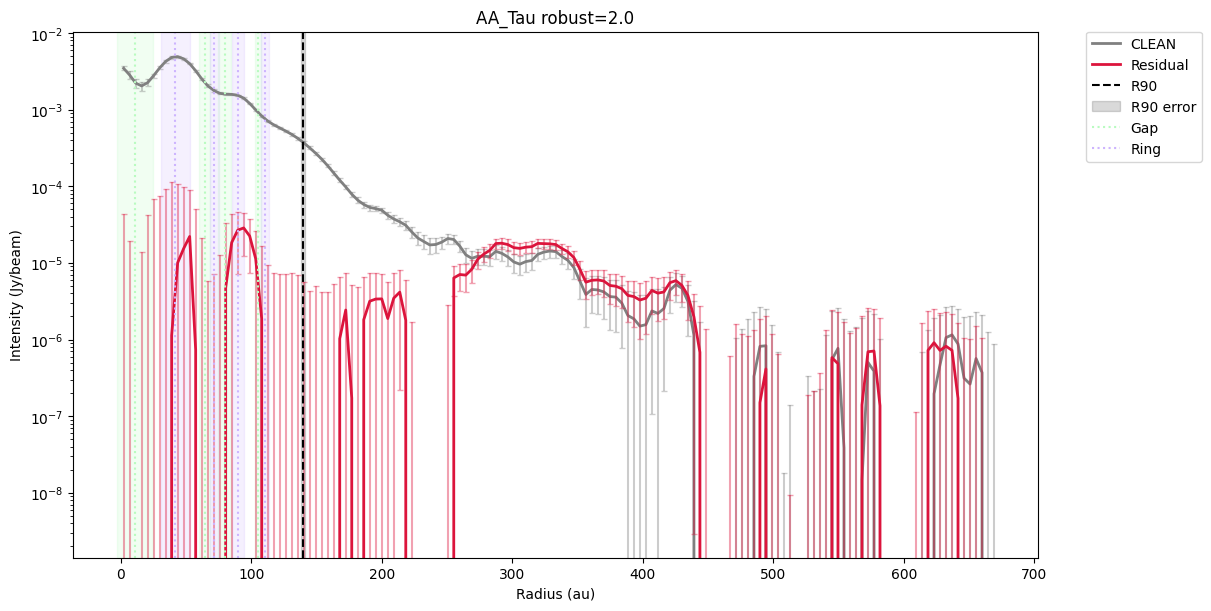

Plotting: CQ_Tau
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


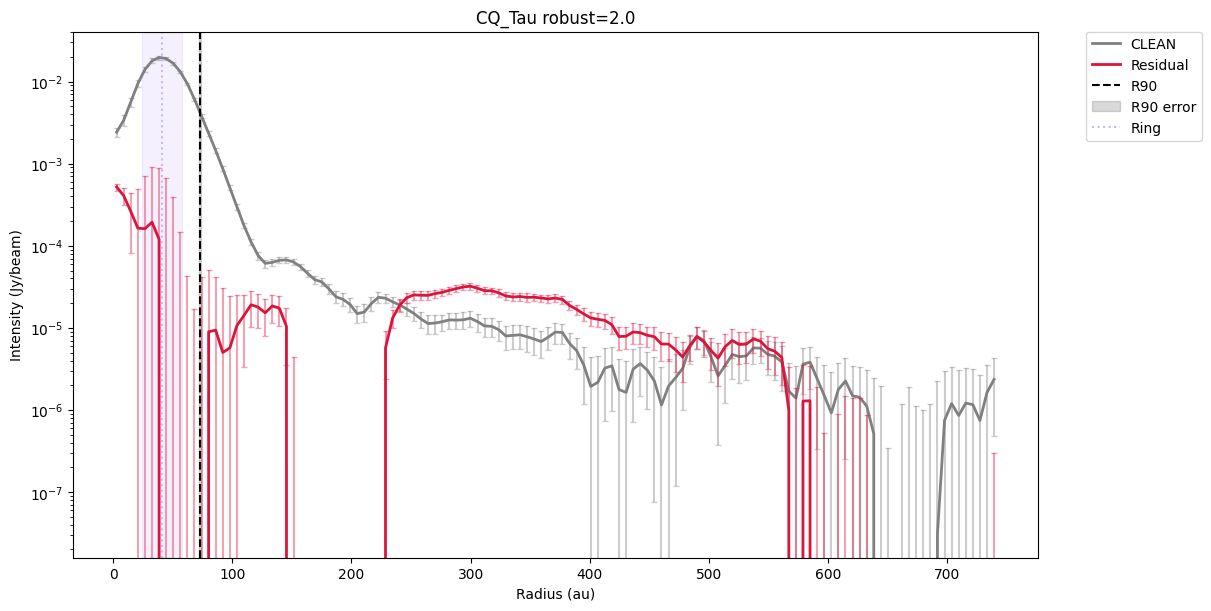

Plotting: DM_Tau
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


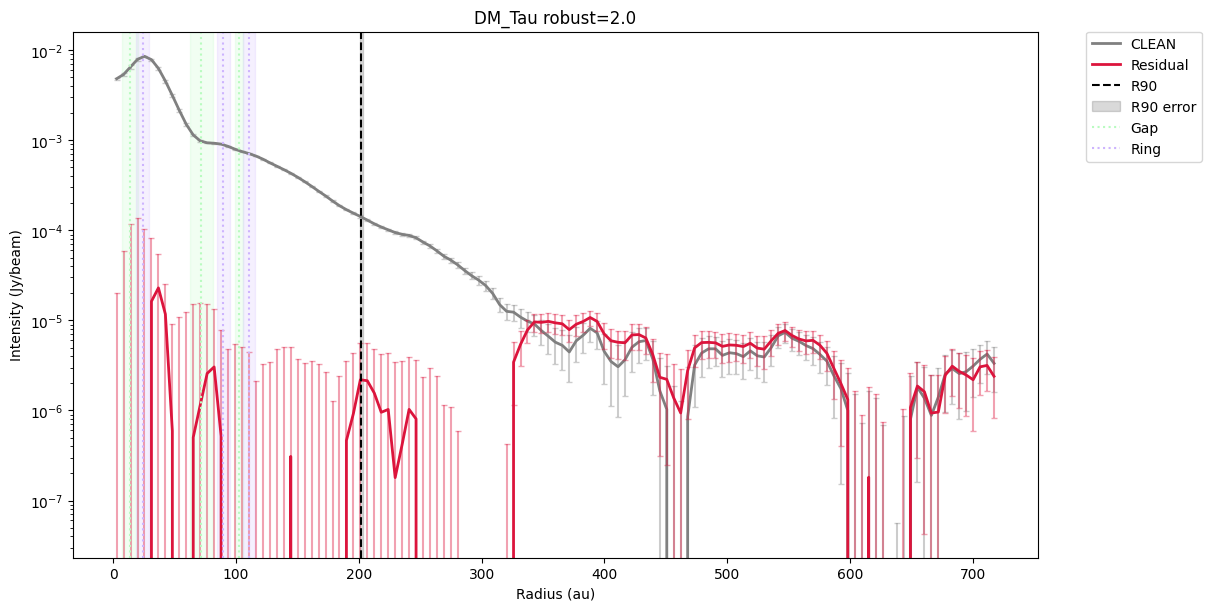

Plotting: HD_135344B
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


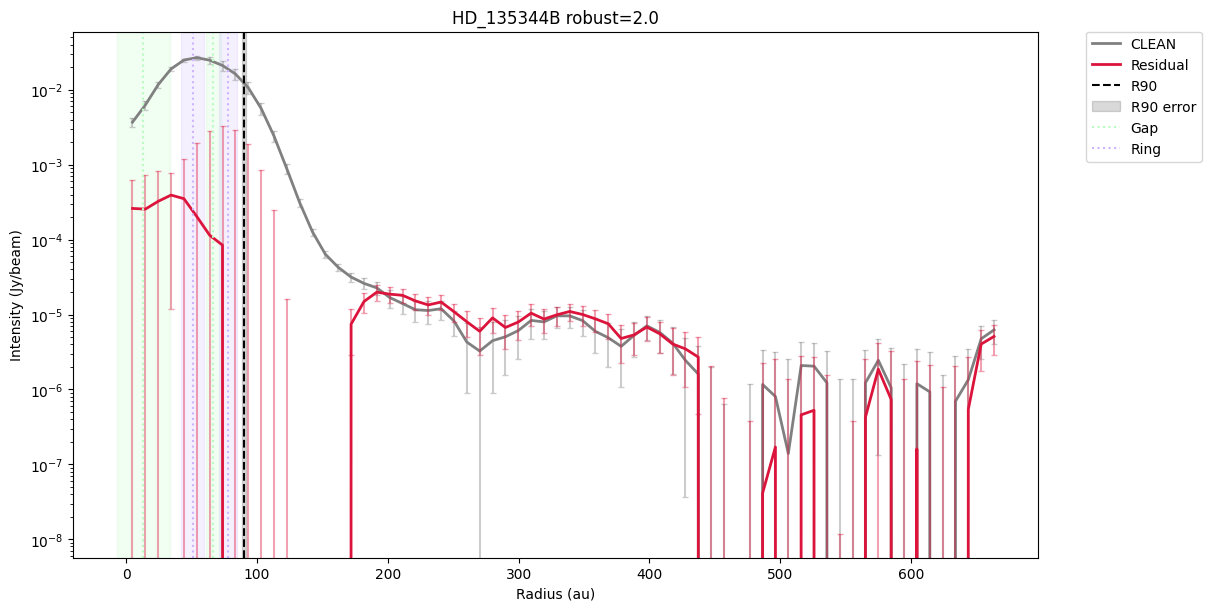

Plotting: HD_143006
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


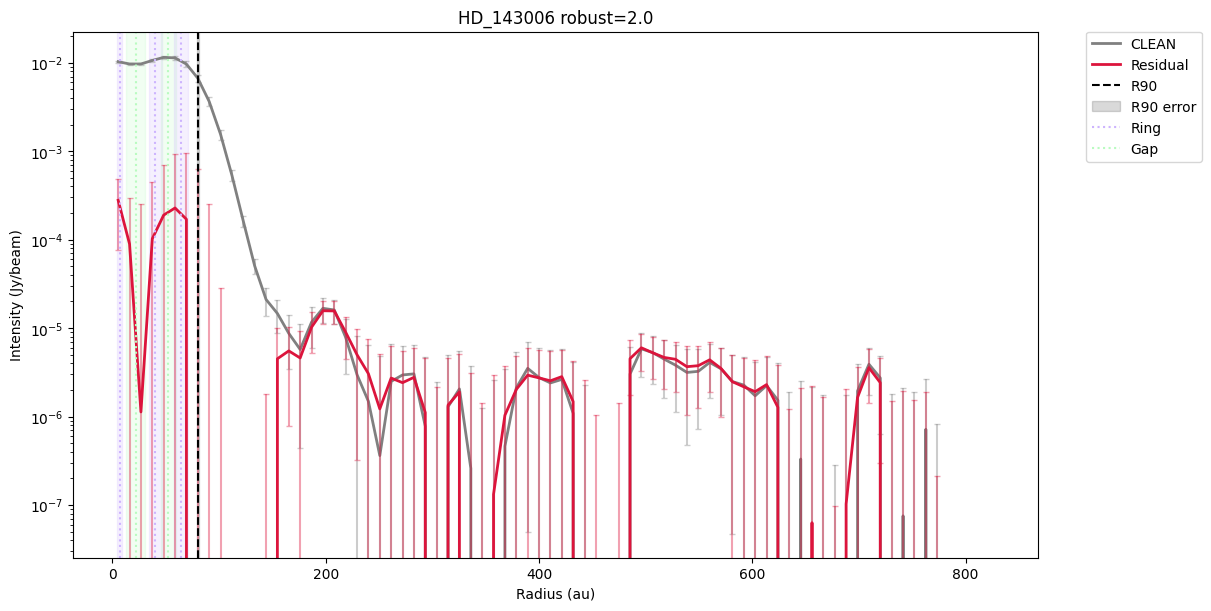

Plotting: HD_34282
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


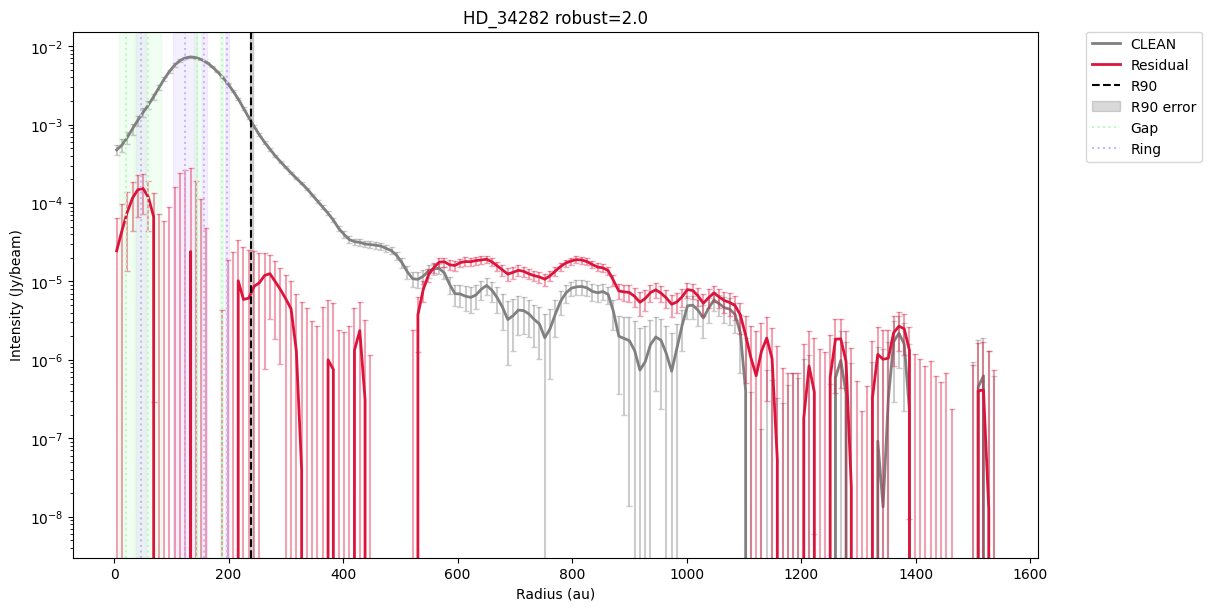

Plotting: J1604
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


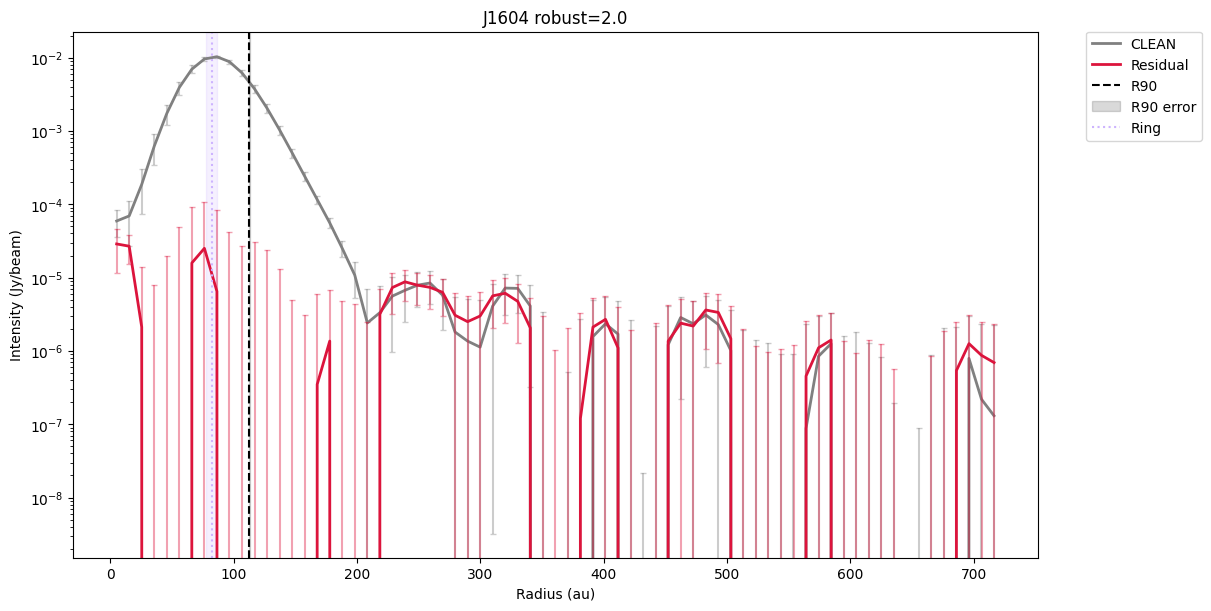

Plotting: J1615
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


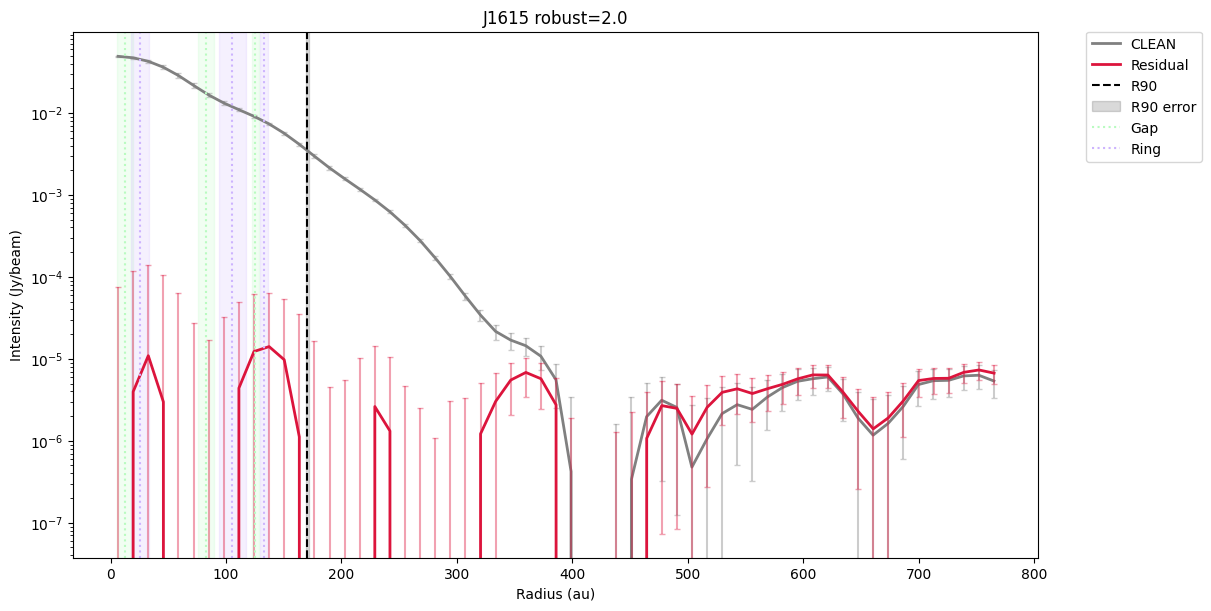

Plotting: J1842
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


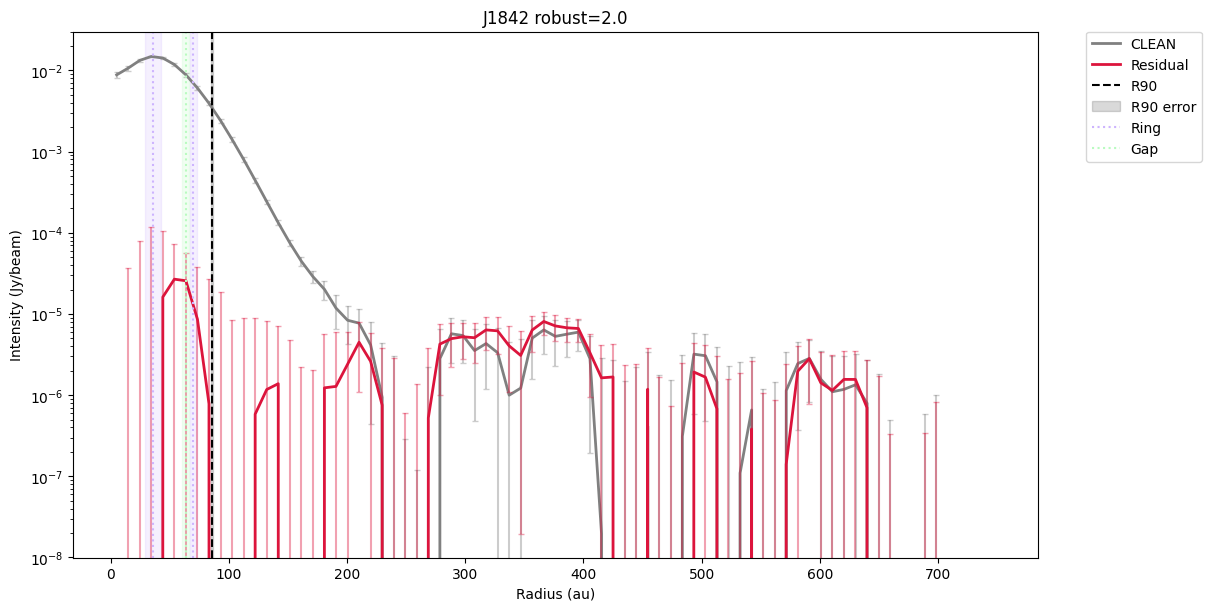

Plotting: J1852
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


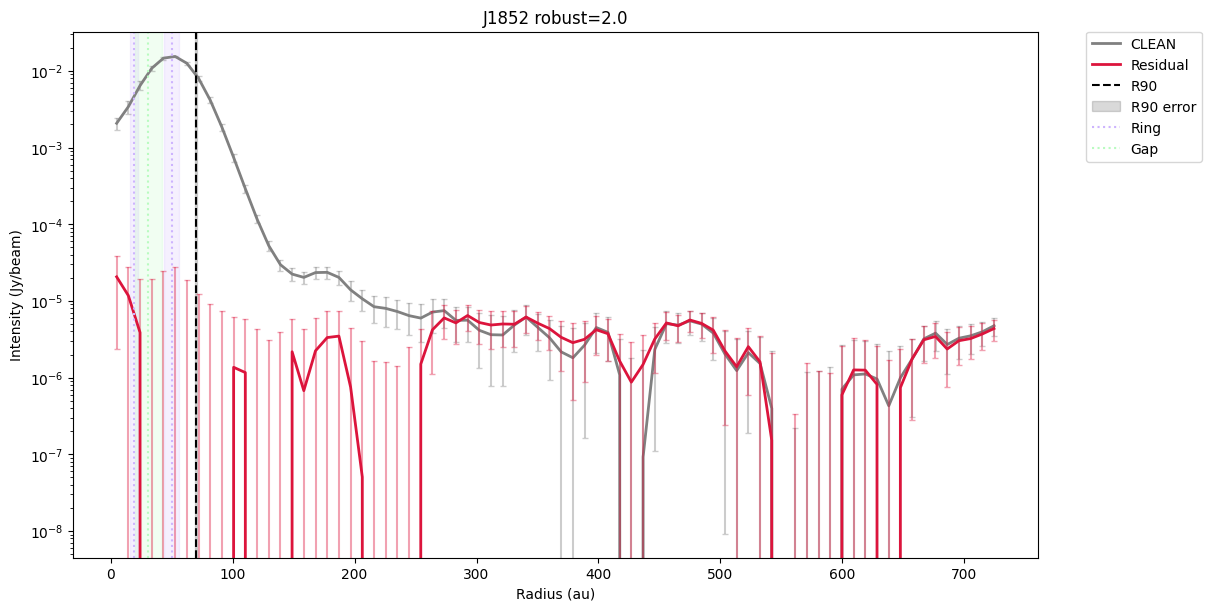

Plotting: LkCa_15
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


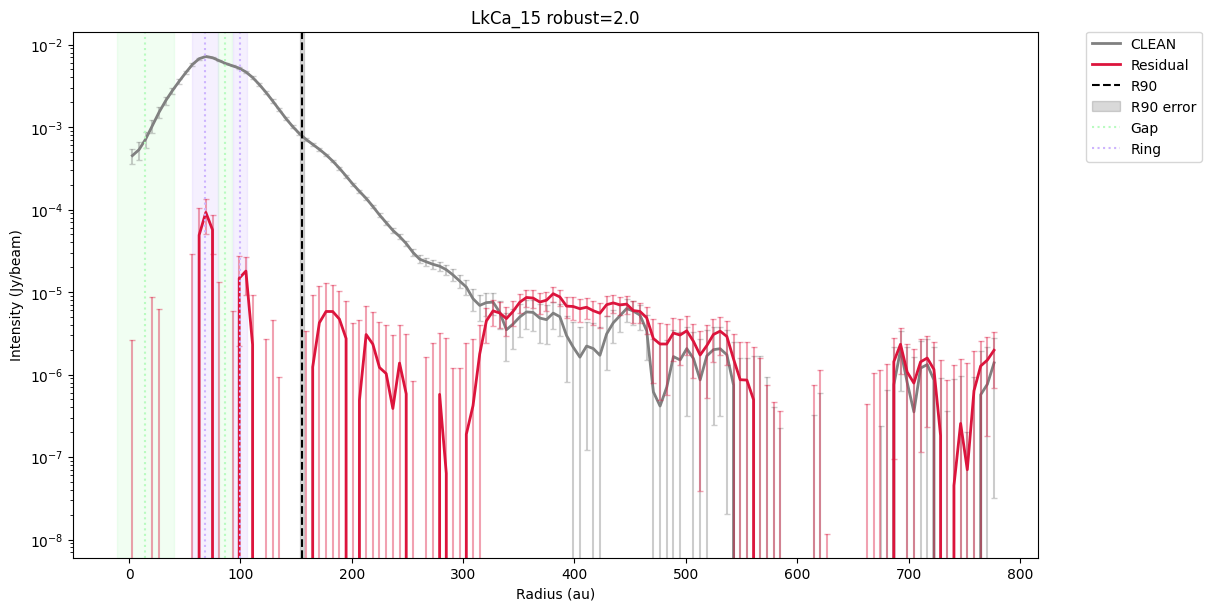

Plotting: MWC_758
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


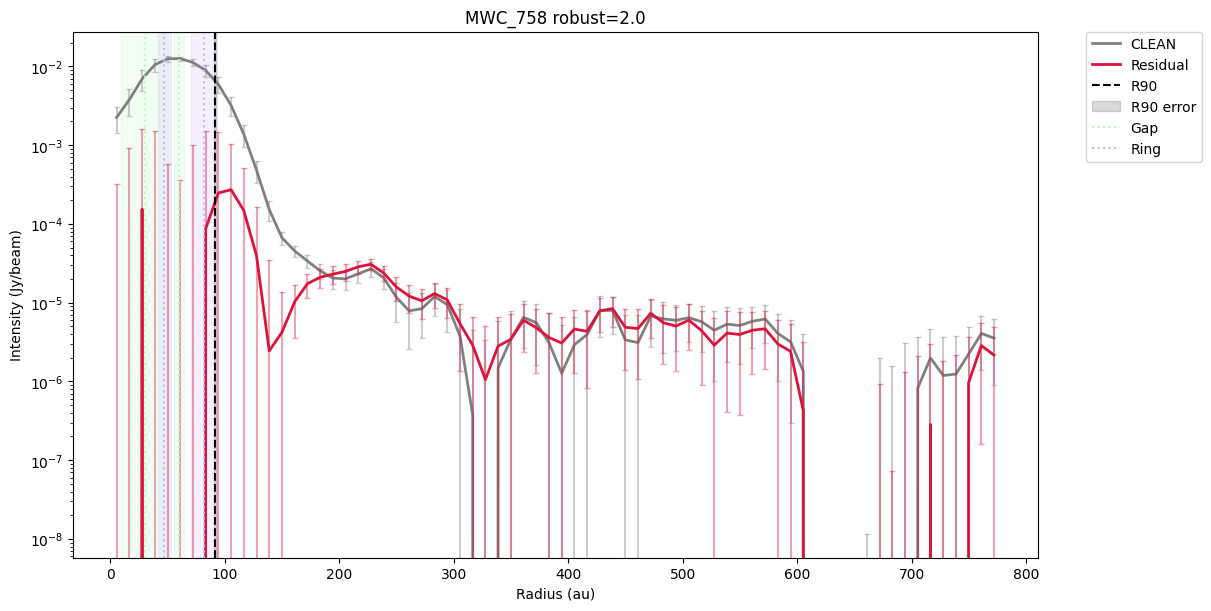

Plotting: PDS_66
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


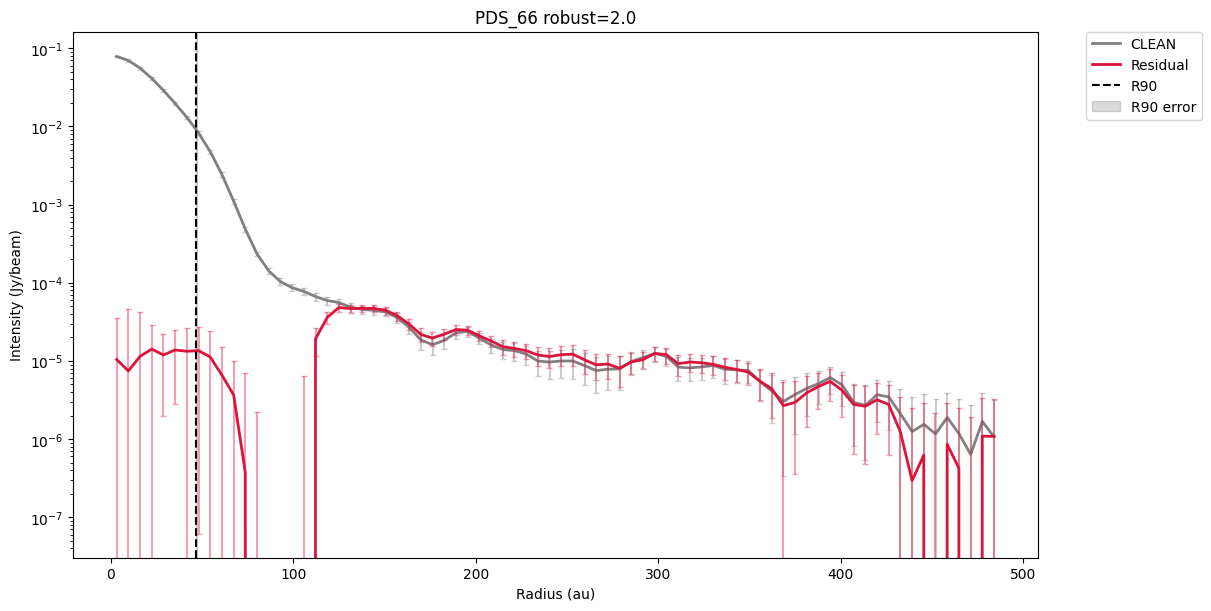

Plotting: SY_Cha
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


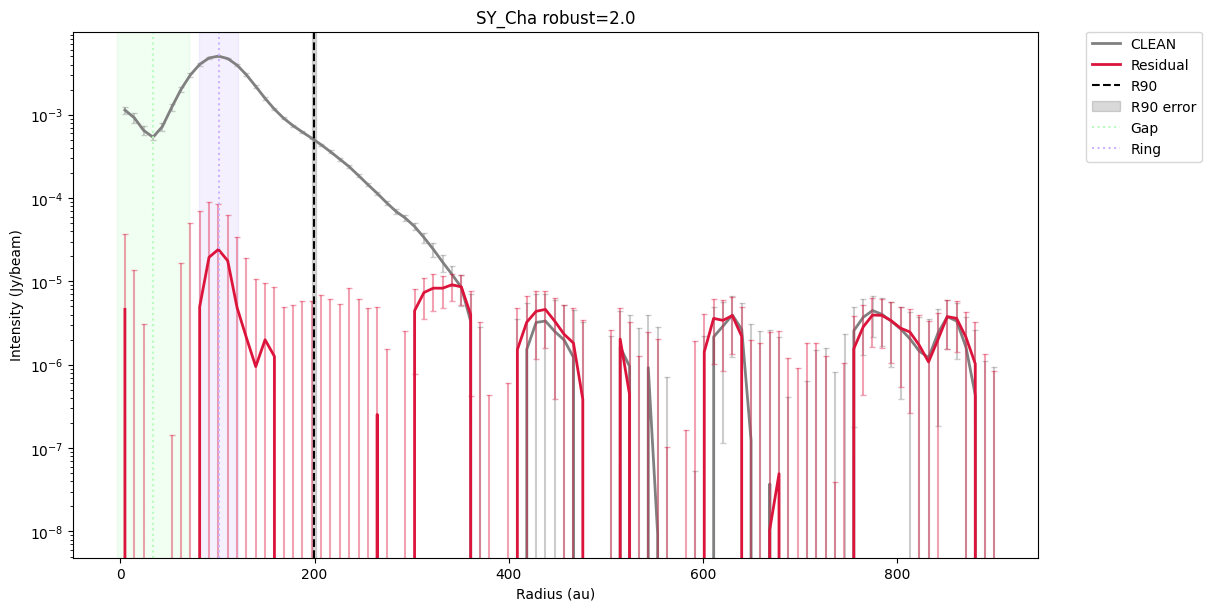

Plotting: V4046_Sgr
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


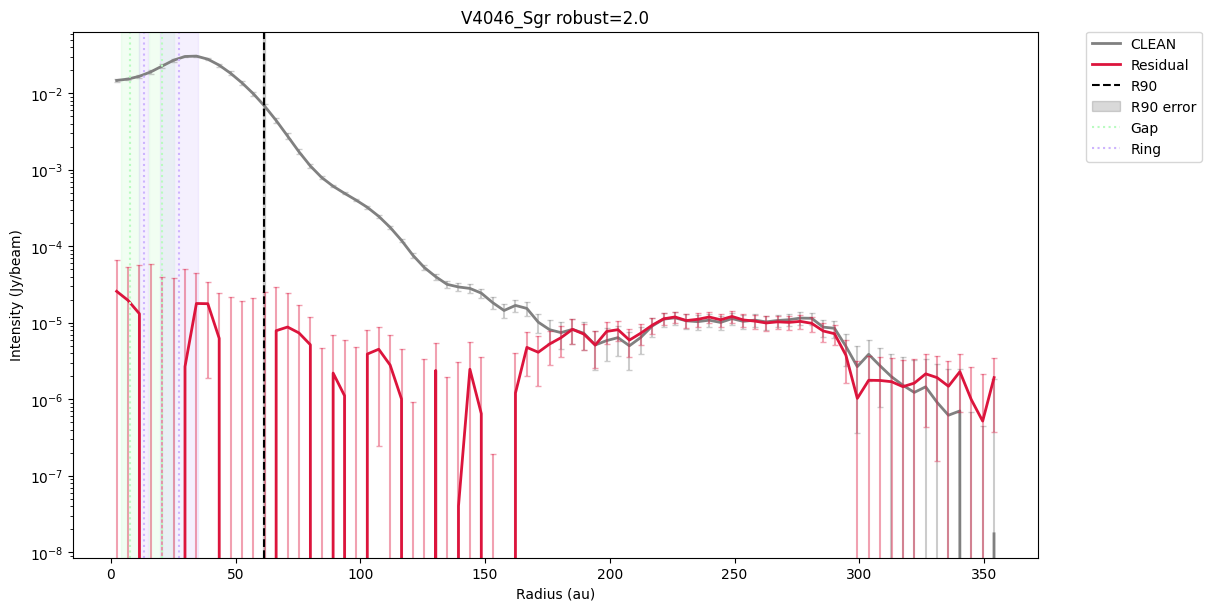

In [10]:
for disk_name, disk_obj in all_disks.items():
    print(f"Plotting: {disk_name}")
    disk_obj.plot_profiles(robust_val="2.0", radius_unit="au")

In [11]:
# Close all plots to save memory 
plt.close('all')

# Signal to Noise evaluation

### Radial Profile Noise and Masking: Key Considerations

A challenge arises because the radial profile is azimuthally averaged. Even if we extract the standard deviation in each annulus, it's unclear how to:

1. Translate that 1D profile back to a 2D map that applies to the clean image.
2. Use it to mask pixels accordingly.

Also, it's important to distinguish between the **standard deviation** and **dy**:

- **Standard deviation**:  
  Measures the spread of beam intensity values within each annulus — i.e., the **noise per beam** in that region.

- **dy**:  
  By default of gofish, represents the *uncertainty on the mean intensity* in each annulus, and is typically calculated as:

  $$
  dy = \frac{\text{std}}{\sqrt{N_{\text{beams}}}}
  $$


  where $ N_{\text{beams}} $ is the number of independent beams in the annulus.




### Radial Uncertainty Estimation in `gofish.py`

The following code snippet shows how the number of **independent beams** is estimated in each annulus:

```python
        # Account for the number of independent beams.
        # Correlation： beams within annulus overlap -> fewer independent pixels -> 
        # only number of beams matter for uncertainty
        # If the beams are assumed to be correlated , then we
        # multiply the number of beams by 2*pi*r/bmaj, which is the
        # number of beams in the annulus.

        if assume_correlated:
            nbeams = 2.0 * np.pi * rvals / self.bmaj  #scales the uncertainty
        else:
            nbeams = 1.0

               # Averaging.

        if percentiles:  
            rstat = np.array([np.percentile(toavg[ridxs == r], [16, 50, 84])  
                              for r in range(1, rbins.size)]).T
            ravgs = rstat[1]
            rstds = np.array([rstat[1] - rstat[0], rstat[2] - rstat[1]])  # the diff betweern the 
                                                                          # 16th and 50th percentiles, 
                                                                          # and the 50th and 84th percentiles
                                                                          #  as lower and upper uncertainties
            rstds /= np.sqrt(nbeams)[None, :]  # divide by the square root of the number of independent beams
        else:
            ravgs = np.array([np.mean(toavg[ridxs == r])
                              for r in range(1, rbins.size)])
            rstds = np.array([np.std(toavg[ridxs == r])
                              for r in range(1, rbins.size)])   # standard deviation of the pixels in 
                                                                #each radial bin
            rstds /= np.sqrt(nbeams)
        
```

I can also try setting `percentiles=True` in `_radial_profile_2D()` to estimate the residual standard deviation using the 16th–84th percentile range, instead of the standard deviation. This might be more robust if the distribution within bins is non-Gaussian.


In [12]:
# Create a 2D sigma map for each disk (Briggs index 2.0)

for disk_name, disk_obj in all_disks.items():
    print(f"Creating sigma mask for: {disk_name}")
    
        # This is the correct method name and parameters
    sigma_2d, (x, y, dy) = disk_obj.create_sigma_mask(
        robust_val="2.0", 
        scale_factor=1.0,  # 3-sigma threshold
            save_fits=True     # Files are automatically saved
    )
        
    print(f" {disk_name}: Sigma mask created and saved")

Creating sigma mask for: AA_Tau
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
Saved sigma mask: Disk_Residual_Profile\AA_Tau\AA_Tau_sigma_mask_robust2.0.fits
 AA_Tau: Sigma mask created and saved
Creating sigma mask for: CQ_Tau
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
Saved sigma mask: Disk_Residual_Profile\CQ_Tau\CQ_Tau_sigma_mask_robust2.0.fits
 CQ_Tau: Sigma mask created and saved
Creating sigma mask for: DM_Tau
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
Saved sigma mask: Disk_Residual_Profile\DM_Tau\DM_Tau_sigma_mask_robust2.0.fits
 DM_Tau: Sigma mask created and saved
Creating sigma mask for: HD_135344B
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
Saved sigma mask: Disk_Residual_Profile\HD_135344B\HD_135344B_sigma_mask_robust2.0.fits
 HD_135344B: Sigma mask created and saved
Creating sigma mask for: HD_143006
	 Reverting to standard azimuthal averaging; will ign

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


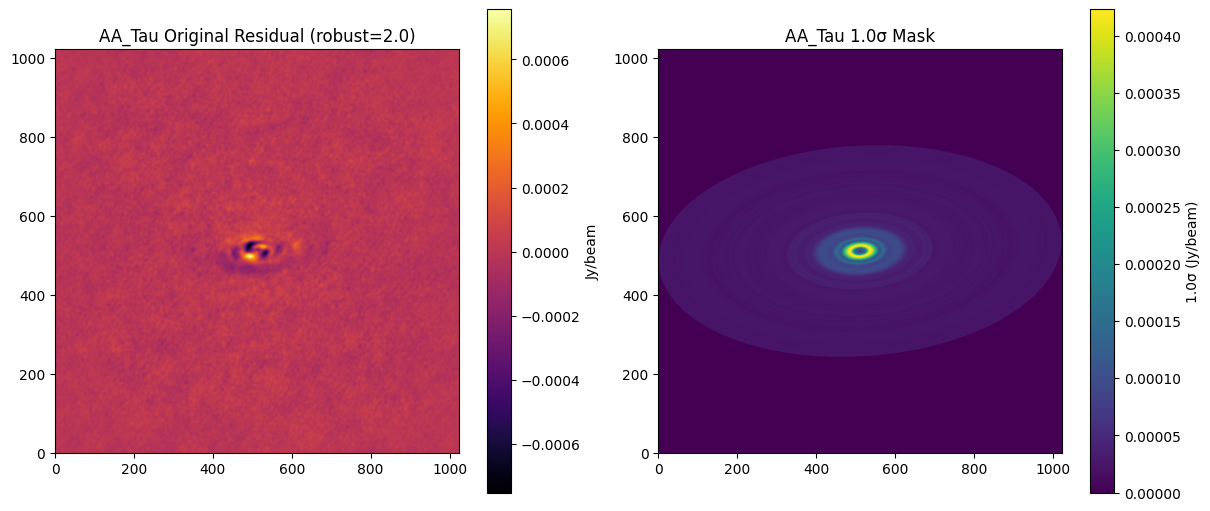

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


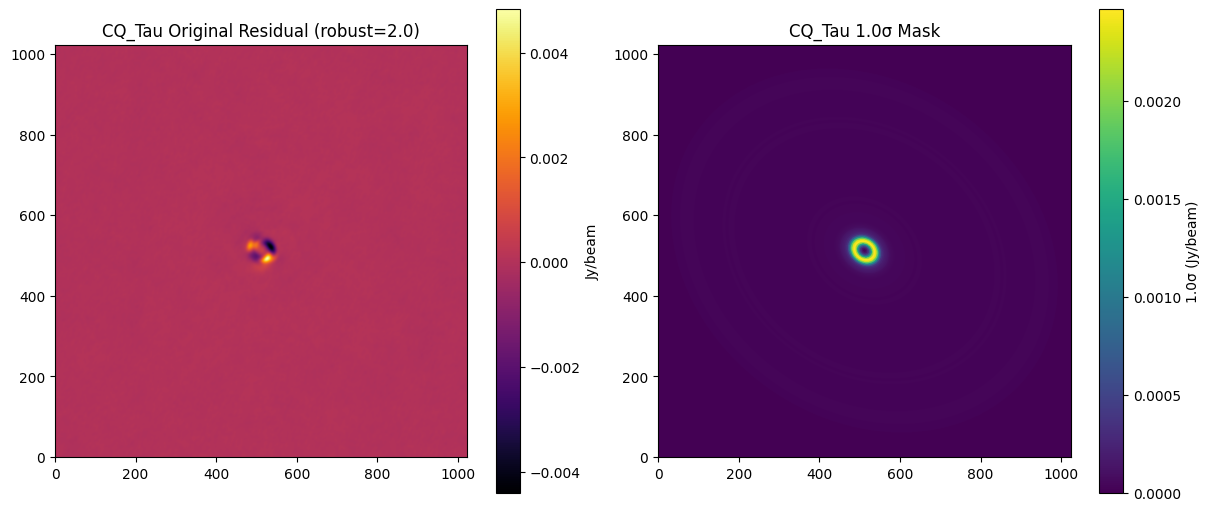

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


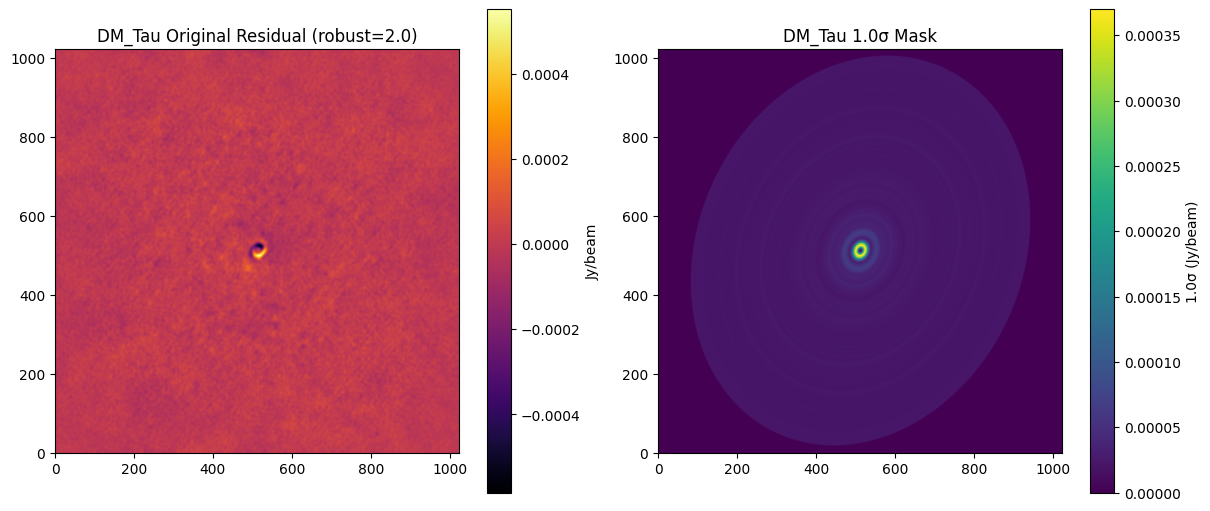

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


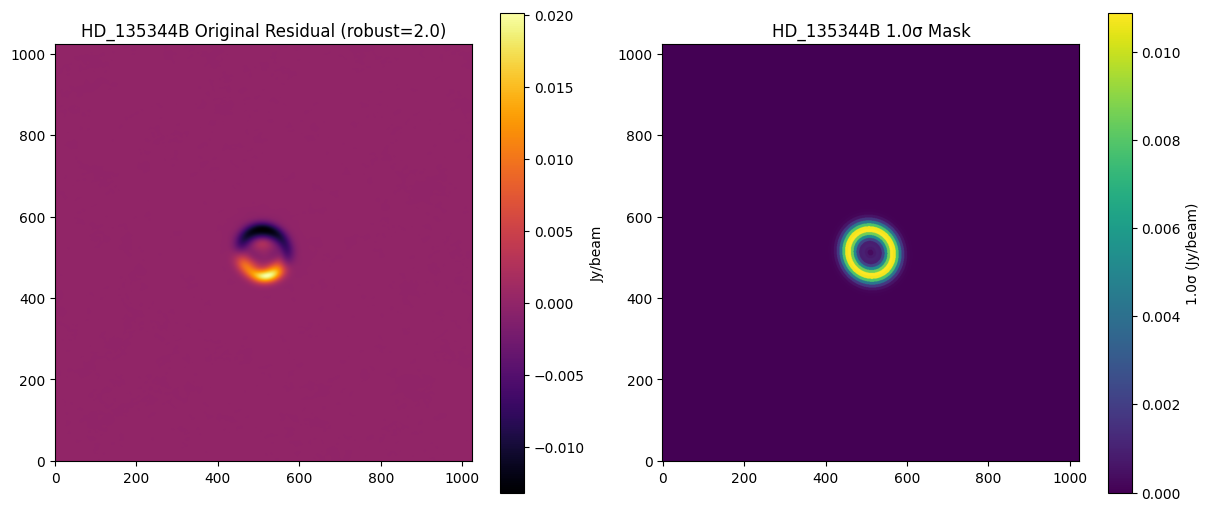

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


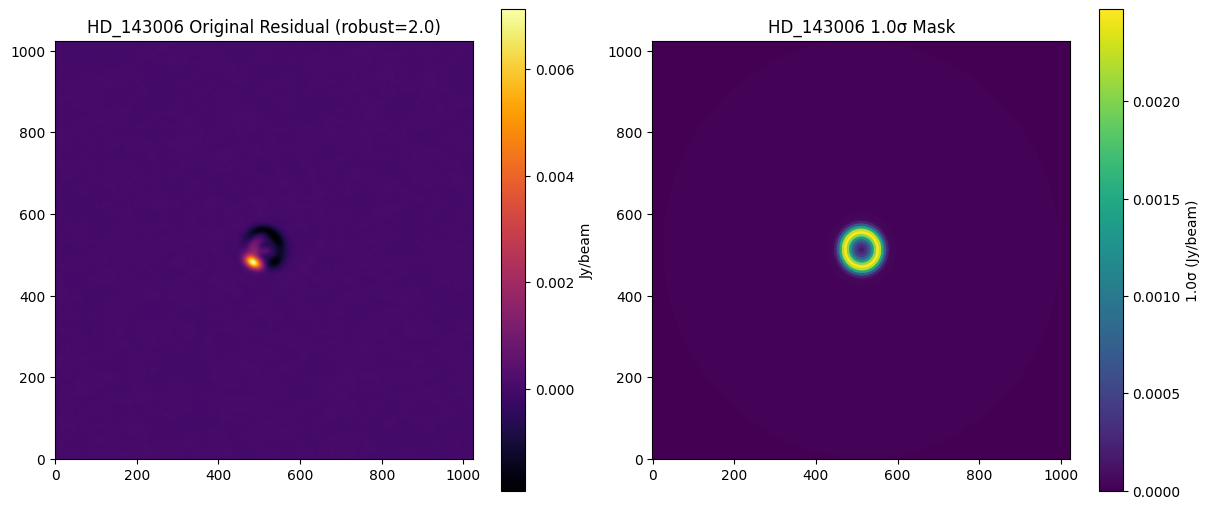

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


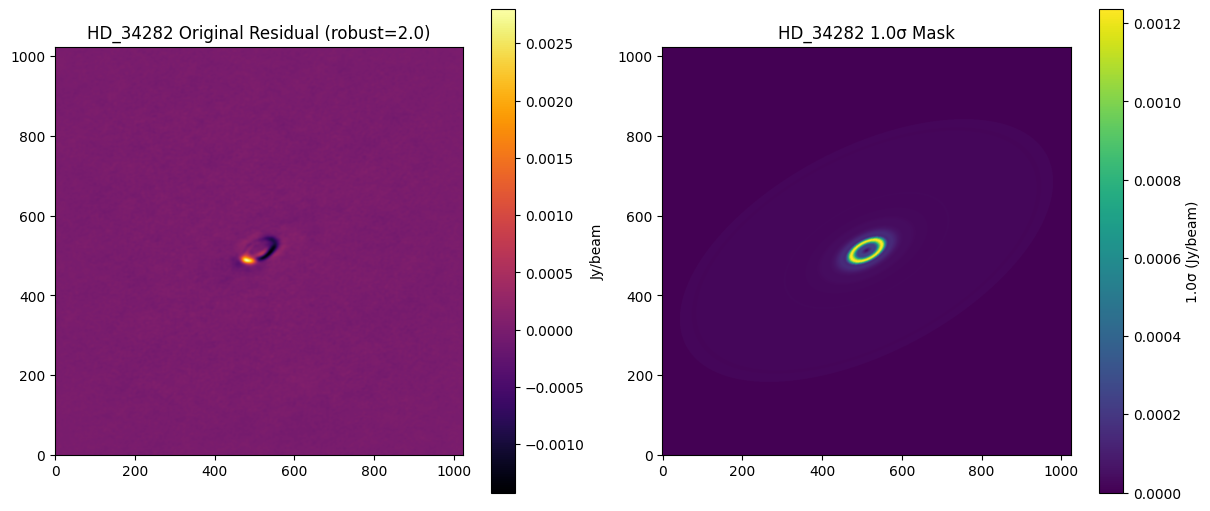

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


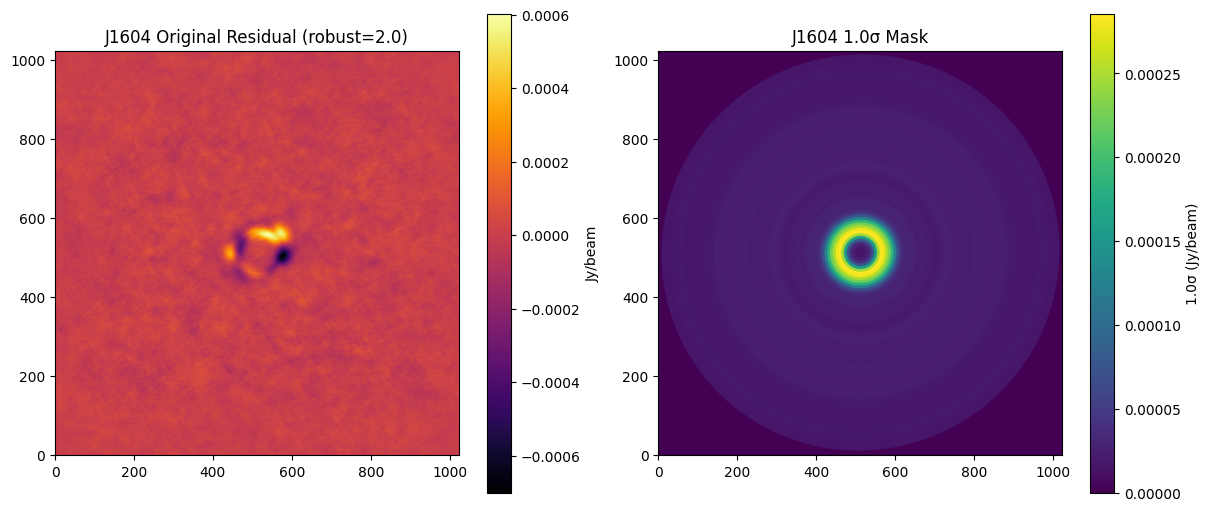

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


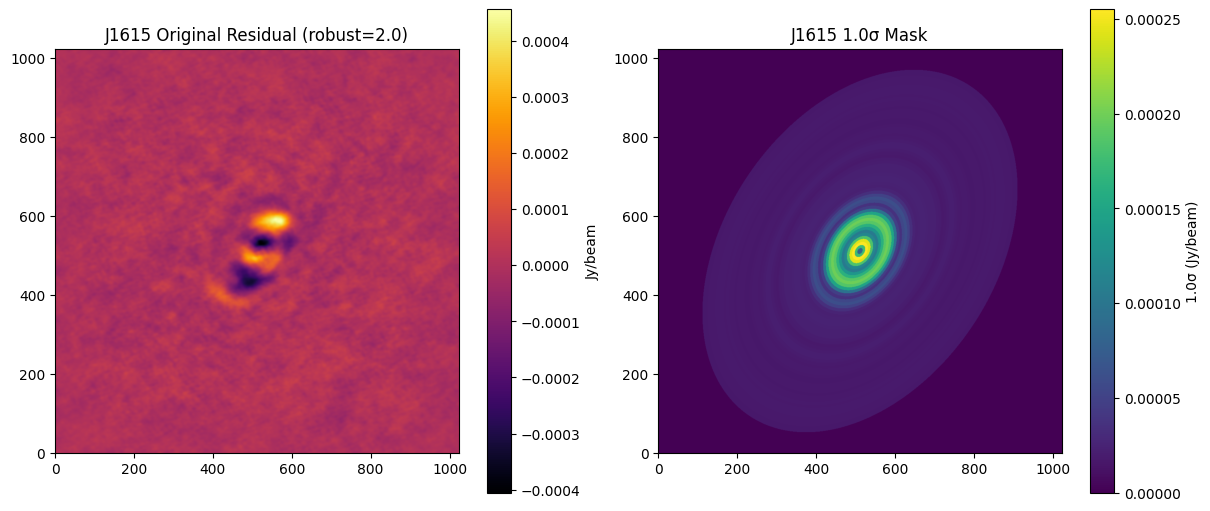

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


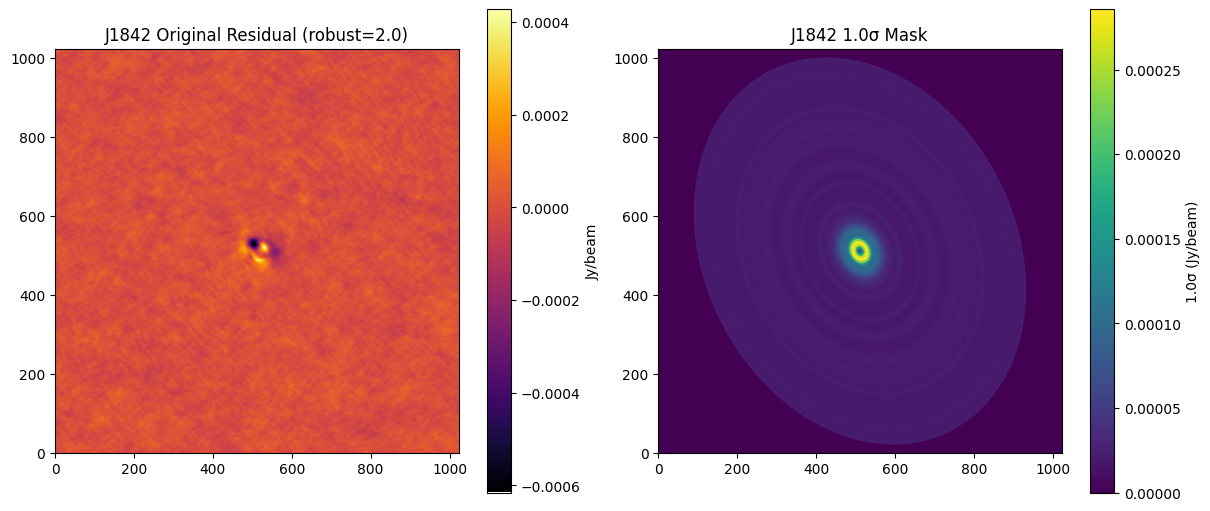

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


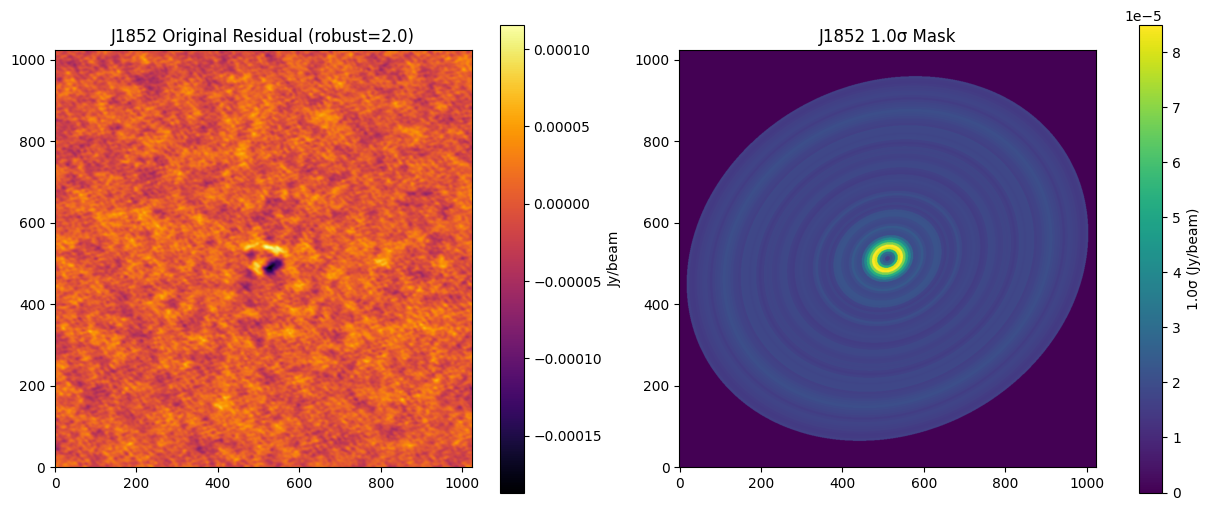

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


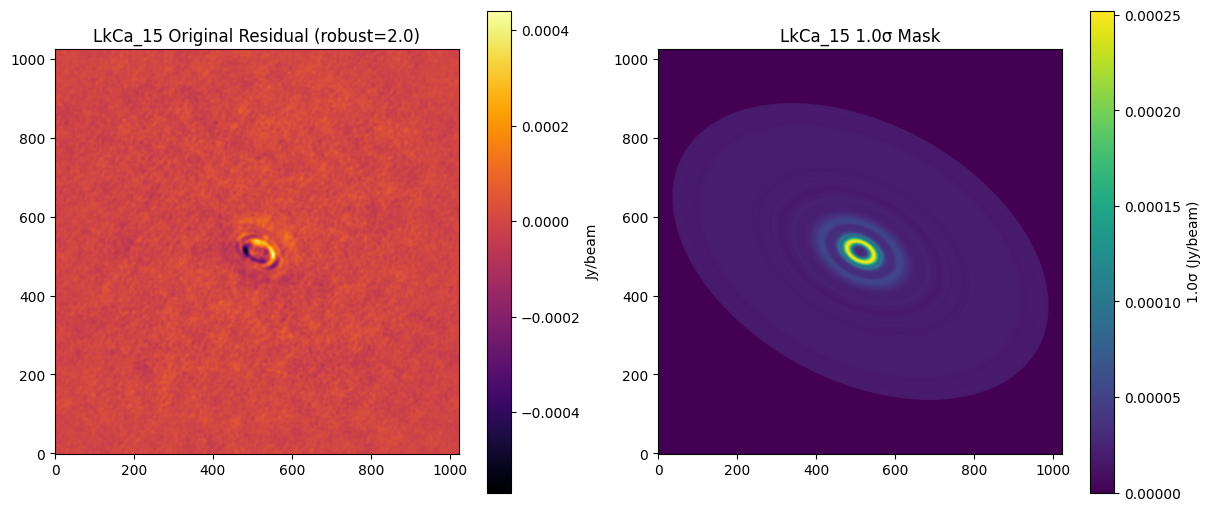

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


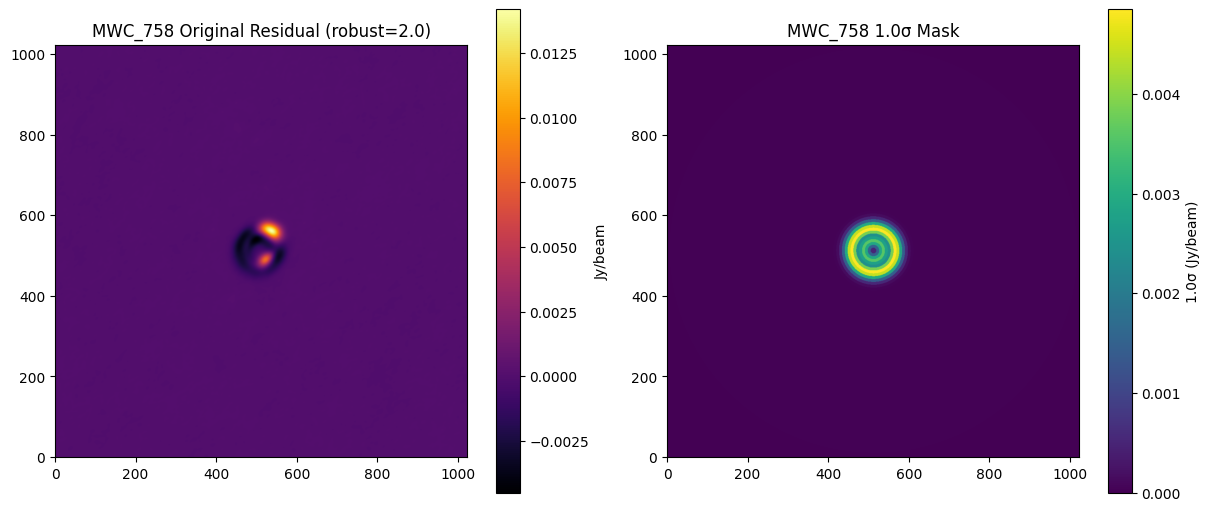

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


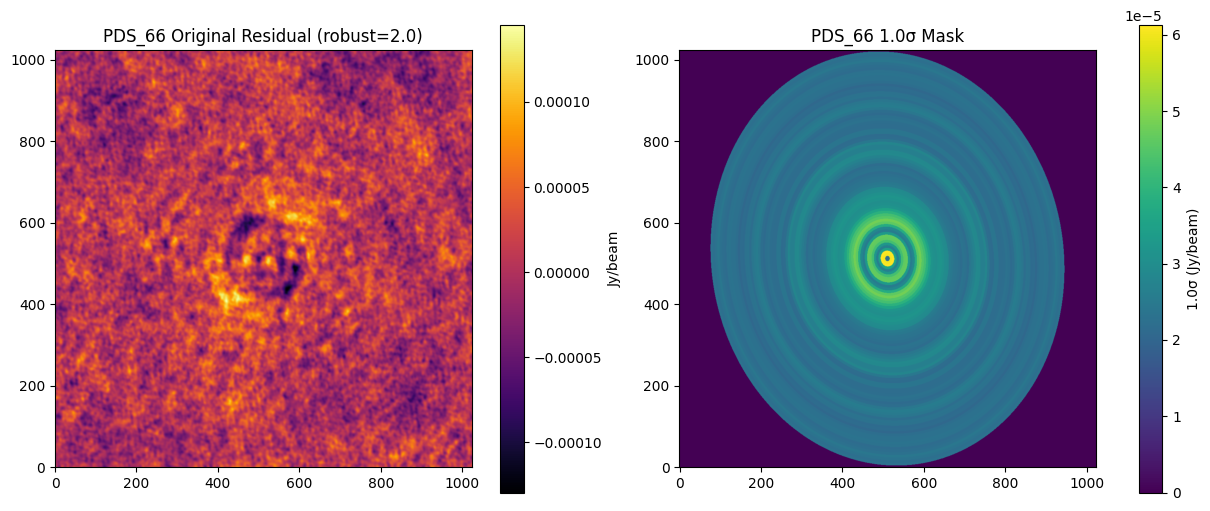

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


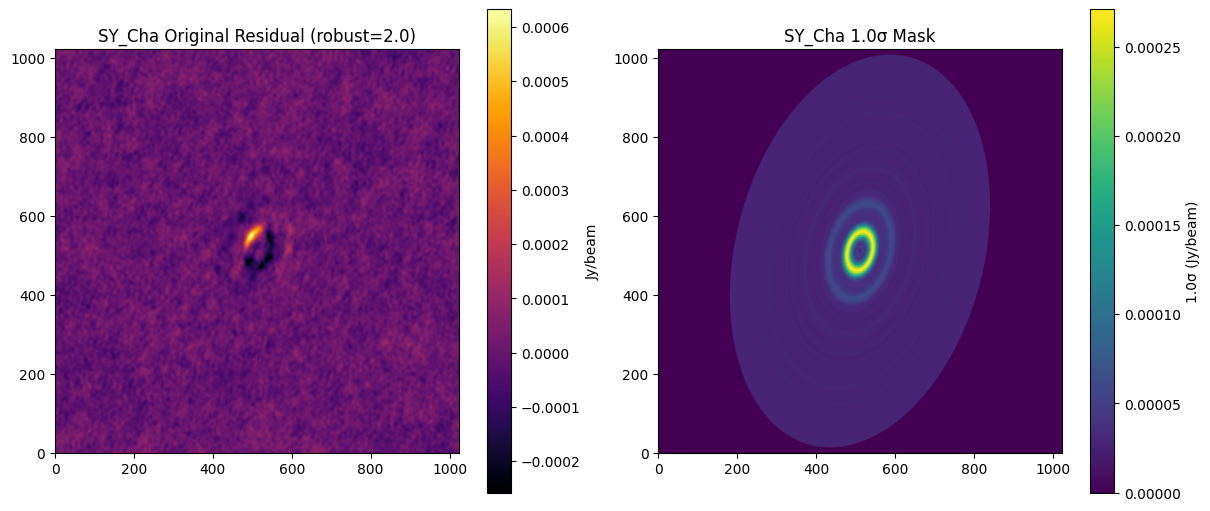

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


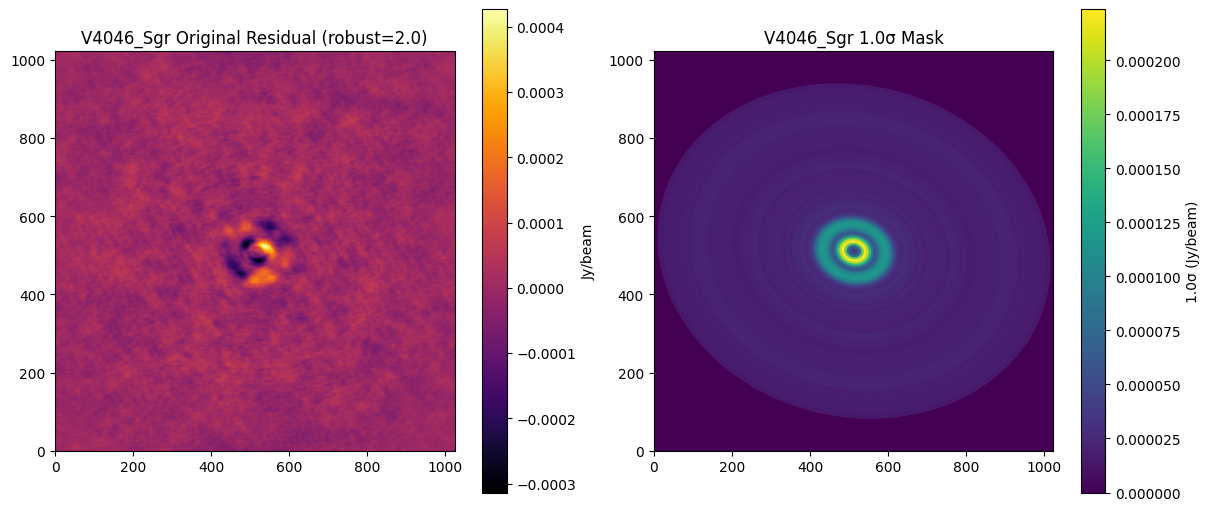

In [13]:
# Plot them  side by side

for disk_name, disk_obj in all_disks.items():
    
    disk_obj.plot_sigma_comparison(robust_val="2.0", scale_factor=1.0)
        


In [14]:
# Close all plots to save memory
plt.close('all')



Question: If the background has negative residual intensity, but there’s a local emission source within it that is significantly brighter (SNR > 5),  would using a high SNR threshold still be reliable for source detection? Or could it lead to missed detections because of the negative background?


If I use the absolute value of the SNR as a threshold, I might not be able to distinguish a truly positive signal within a gap—,since its SNR would be negative,rom a deep negative residual caused solely by the gap itself, with no embedded source.

In [15]:
# Create a 2D SNR map for each disk (Briggs index 2.0)

# Use the actual key format that exists
for disk_name, disk_obj in all_disks.items():
    print(f"Creating SNR map for: {disk_name}")
    
    snr_2d = disk_obj.create_snr_map(robust_val="2.0")  
    
    if snr_2d is not None:
        print(f" {disk_name}: SNR map created successfully")
    else:
        print(f" {disk_name}: Failed to create SNR map")

Creating SNR map for: AA_Tau
  AA_Tau: Sigma shape: (1024, 1024), Residual shape: (1024, 1024)
 AA_Tau: SNR map created successfully
Creating SNR map for: CQ_Tau
  CQ_Tau: Sigma shape: (1024, 1024), Residual shape: (1024, 1024)
 CQ_Tau: SNR map created successfully
Creating SNR map for: DM_Tau
  DM_Tau: Sigma shape: (1024, 1024), Residual shape: (1024, 1024)
 DM_Tau: SNR map created successfully
Creating SNR map for: HD_135344B
  HD_135344B: Sigma shape: (1024, 1024), Residual shape: (1024, 1024)
 HD_135344B: SNR map created successfully
Creating SNR map for: HD_143006
  HD_143006: Sigma shape: (1024, 1024), Residual shape: (1024, 1024)
 HD_143006: SNR map created successfully
Creating SNR map for: HD_34282
  HD_34282: Sigma shape: (1024, 1024), Residual shape: (1024, 1024)
 HD_34282: SNR map created successfully
Creating SNR map for: J1604
  J1604: Sigma shape: (1024, 1024), Residual shape: (1024, 1024)
 J1604: SNR map created successfully
Creating SNR map for: J1615
  J1615: Sigma sh

In [22]:
# Source detection using the SNR map

for disk_name, disk_obj in all_disks.items():
    print(f"Running source detection for: {disk_name}")
    snr_map = disk_obj.create_snr_map(robust_val="2.0")
    if snr_map is not None:
        disk_obj.source_detection(snr_map, robust_val="2.0", threshold=5.0)
    else:
        print(f"  Skipping {disk_name}: SNR map not available")


Running source detection for: AA_Tau
  Pixel scale: 1.4 AU/pixel
  Detected 1 sources
  Saved source catalog to Disk_Residual_Profile\AA_Tau\robust_2.0\source_catalog_AA_Tau_robust2.0_thresh5p0.txt
Running source detection for: CQ_Tau
  Pixel scale: 1.5 AU/pixel
  Detected 1 sources
  Saved source catalog to Disk_Residual_Profile\CQ_Tau\robust_2.0\source_catalog_CQ_Tau_robust2.0_thresh5p0.txt
Running source detection for: DM_Tau
  Pixel scale: 1.4 AU/pixel
  No sources detected above 5.0σ
Running source detection for: HD_135344B
  Pixel scale: 1.4 AU/pixel
  No sources detected above 5.0σ
Running source detection for: HD_143006
  Pixel scale: 1.7 AU/pixel
  No sources detected above 5.0σ
Running source detection for: HD_34282
  Pixel scale: 3.1 AU/pixel
  Detected 2 sources
  Saved source catalog to Disk_Residual_Profile\HD_34282\robust_2.0\source_catalog_HD_34282_robust2.0_thresh5p0.txt
Running source detection for: J1604
  Pixel scale: 1.5 AU/pixel
  No sources detected above 5.0σ
Ru

In [21]:
# Try for 3 sigma
for disk_name, disk_obj in all_disks.items():
    print(f"Running source detection for: {disk_name}")
    snr_map = disk_obj.create_snr_map(robust_val="2.0")
    if snr_map is not None:
        disk_obj.source_detection(snr_map, robust_val="2.0", threshold=3.0)
    else:
        print(f"  Skipping {disk_name}: SNR map not available")

Running source detection for: AA_Tau
  Pixel scale: 1.4 AU/pixel
  Detected 101 sources
  Saved source catalog to Disk_Residual_Profile\AA_Tau\robust_2.0\source_catalog_AA_Tau_robust2.0_thresh3p0.txt
Running source detection for: CQ_Tau
  Pixel scale: 1.5 AU/pixel
  Detected 196 sources
  Saved source catalog to Disk_Residual_Profile\CQ_Tau\robust_2.0\source_catalog_CQ_Tau_robust2.0_thresh3p0.txt
Running source detection for: DM_Tau
  Pixel scale: 1.4 AU/pixel
  Detected 183 sources
  Saved source catalog to Disk_Residual_Profile\DM_Tau\robust_2.0\source_catalog_DM_Tau_robust2.0_thresh3p0.txt
Running source detection for: HD_135344B
  Pixel scale: 1.4 AU/pixel
  Detected 108 sources
  Saved source catalog to Disk_Residual_Profile\HD_135344B\robust_2.0\source_catalog_HD_135344B_robust2.0_thresh3p0.txt
Running source detection for: HD_143006
  Pixel scale: 1.7 AU/pixel
  Detected 121 sources
  Saved source catalog to Disk_Residual_Profile\HD_143006\robust_2.0\source_catalog_HD_143006_rob

In [ ]:

import os
import glob
import pandas as pd

def source_detection_summary(robust_val, threshold_str):
    """
    Summarizes the source detection results from catalog files.

    Returns:
    - summary_df: DataFrame containing disk names and number of sources detected.
    """
    summary = []

    base_path = "Disk_Residual_Profile"

    # Find all matching catalog files
    pattern = f"{base_path}/*/robust_{robust_val}/source_catalog_*_robust{robust_val}_thresh{threshold_str}.txt"
    catalog_files = glob.glob(pattern)

    for file in catalog_files:
        disk_name = os.path.basename(file).split("_robust")[0].replace("source_catalog_", "")
        df = pd.read_csv(file, comment=None, delim_whitespace=True, skiprows=1, names=[
        'xcentroid', 'ycentroid', 'area', 'max_value', 'radius_au'
        ])
        n_sources = len(df)
        summary.append((disk_name, n_sources))

    # Convert to DataFrame
    summary_df = pd.DataFrame(summary, columns=["Disk Name", "Sources Detected"])
    summary_df = summary_df.sort_values("Disk Name")
    return summary_df


source_detection_summary( robust_val = "2.0", threshold_str = "3p0")

Disk Name  Sources Detected
0       AA_Tau               101
1       CQ_Tau               196
2       DM_Tau               183
3   HD_135344B               108
4    HD_143006               121
5     HD_34282               142
6        J1604               112
7        J1615               101
8        J1842                69
9        J1852                77
10     LkCa_15               137
11     MWC_758               219
12      PDS_66               172
13      SY_Cha                61
14   V4046_Sgr               123

In [33]:
source_detection_summary( robust_val = "2.0", threshold_str = "5p0")

Disk Name  Sources Detected
0    AA_Tau                 1
1    CQ_Tau                 1
2  HD_34282                 2
3   MWC_758                 5

The next step is to run the source detection algorithm across all robust values to inspect if the high SNR source appears repeatedly. There are two tasks to accomplish:

1. Ensure the field of view of both the residual map and the residual profile matches that of the original image.

2. Double-check the parameters used for source detection and explore alternative methods for source detection.

    Alternatively, a more straightforward approach is to save the SNR map (after ensuring the SNR is computed reliably and accurately) to a FITS (construct the header with caution, not just copy clean image header) and manually contour the high SNR region using CARTA.

In [36]:
# Run the source detection function for all robust values and thresholds (3.0 and 5.0)
robust_vals = ["-2.0", "-1.5", "-1.0", "-0.5", "0.0", "0.5", "1.0", "1.5", "2.0"]
thresholds = [3.0, 5.0]

for disk_name, disk_obj in all_disks.items():
    for r in robust_vals:
        # Check the residual files are present
        resid_path = os.path.join(
            "D:/exoALMA_disk_data",
            disk_name,
            "images_frank_residuals_different_robust",
            f"{disk_name}_continuum_resid_robust{r}.image.fits"
        )
        
        # Skip if file does not exist
        if not os.path.exists(resid_path):
            print(f"Skipping {disk_name} (robust {r}): residual file not found.")
            continue

        try:
            sigma_2d = disk_obj.create_sigma_mask(robust_val=r, scale_factor=1.0, save_fits=True)
            snr_map = disk_obj.create_snr_map(robust_val=r)
            if snr_map is not None:
                for t in thresholds:
                    disk_obj.source_detection(snr_map, robust_val=r, threshold=t)
        except Exception as e:
            print(f"Error processing {disk_name} (robust {r}): {e}")

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
Saved sigma mask: Disk_Residual_Profile\AA_Tau\AA_Tau_sigma_mask_robust-2.0.fits
  Pixel scale: 1.4 AU/pixel
  Detected 181 sources
  Saved source catalog to Disk_Residual_Profile\AA_Tau\robust_-2.0\source_catalog_AA_Tau_robust-2.0_thresh3p0.txt
  Pixel scale: 1.4 AU/pixel
  No sources detected above 5.0σ
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
Saved sigma mask: Disk_Residual_Profile\AA_Tau\AA_Tau_sigma_mask_robust-1.5.fits
  Pixel scale: 1.4 AU/pixel
  Detected 172 sources
  Saved source catalog to Disk_Residual_Profile\AA_Tau\robust_-1.5\source_catalog_AA_Tau_robust-1.5_thresh3p0.txt
  Pixel scale: 1.4 AU/pixel
  No sources detected above 5.0σ
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
Saved sigma mask: Disk_Residual_Profile\AA_Tau\AA_Tau_sigma_mask_robust-1.0.fits
  Pixel scale: 1.4 AU/pixel
  Detected 168 sources
  Saved source catalog to Disk_R

In [ ]:
# Display the comparison of source detection results for all robust values for each disk in a table format:
def get_disk_detection_summary(disk_name, robust_vals, thresholds):
    """
    Generate a summary DataFrame for a single disk.
    Each row: one robust value.
    Each column: number of sources detected at each threshold (3.0  and 5.0).
    """

    base_path="Disk_Residual_Profile"

    rows = []

    for r in robust_vals:
        row = {"Robust": r}
        for t in thresholds:
            threshold_str = f"{t}p0"
            try:
                summary_df = source_detection_summary(
                    base_path=base_path,
                    robust_val=r,
                    threshold_str=threshold_str
                )

                match = summary_df[summary_df["Disk Name"] == disk_name]
                if not match.empty:
                    row[f"{t}σ"] = match["Sources Detected"].values[0]
                else:
                    row[f"{t}σ"] = None  # or 0
            except Exception as e:
                row[f"{t}σ"] = None
                print(f"Disk: {disk_name}, Robust: {r}, Threshold {t} — Error: {e}")
        rows.append(row)

    return pd.DataFrame(rows)




Disk: AA_Tau
Threshold: 3.0
  Robust -2.0, Threshold 3.0: No data available
  Robust -1.5, Threshold 3.0: No data available
  Robust -1.0, Threshold 3.0: No data available
  Robust -0.5, Threshold 3.0: No data available
  Robust 0.0, Threshold 3.0: No data available
  Robust 0.5, Threshold 3.0: No data available
  Robust 1.0, Threshold 3.0: No data available
  Robust 1.5, Threshold 3.0: No data available
  Robust 2.0, Threshold 3.0: No data available
Threshold: 5.0
  Robust -2.0, Threshold 5.0: No data available
  Robust -1.5, Threshold 5.0: No data available
  Robust -1.0, Threshold 5.0: No data available
  Robust -0.5, Threshold 5.0: No data available
  Robust 0.0, Threshold 5.0: No data available
  Robust 0.5, Threshold 5.0: No data available
  Robust 1.0, Threshold 5.0: No data available
  Robust 1.5, Threshold 5.0: No data available
  Robust 2.0, Threshold 5.0: No data available

Disk: CQ_Tau
Threshold: 3.0
  Robust -2.0, Threshold 3.0: No data available
  Robust -1.5, Threshold 

# Plot Dust Mass Versus Dust Size Profile

*One-sentence summary for Figure 3 in SR12c paper*
The dust mass required to produce a given observed flux, as a function of disk outer radius, under assumed disk parameters (like temperature, opacity, and surface density slope).

**Interpretation of figure 3**
- For disks larger than approximately 1 astronomical unit (au), the dust mass becomes relatively independent of the outer radius, which signifies an optically thin dust emission. 

- Conversely, for disks smaller than about 1 au, the curves become vertical. This indicates that the disks are optically thick, and a smaller disk requires a significantly higher mass to produce the same observed flux. 

In [17]:
# Let 3*sigma be the flux limit for each annulus
# Assume a temperature , surface density, opacity to plot an example profile for one annulus
# project the dy_values back to a 2D image, scale it up by 3 sigma and use it as a mask
# Pinpoint the outliers in position and plot them
#to project a 1D radial standard deviation profile (like σ(r)) back onto a 2D map (to match your residual FITS image)


